# Pictures compression using SVD
In this exercise you are supposed to study how SVD could be used in image compression.

_Based on open course in [Numerical Linear Algebra](https://github.com/oseledets/nla2018) by Ivan Oseledets_

In [9]:
# !pip install wget

import wget, os

url_0 = "https://raw.githubusercontent.com/girafe-ai/ml-course/a5bf18c/datasets/waiting.jpeg"
url_1 = "https://raw.githubusercontent.com/girafe-ai/ml-course/a5bf18c/datasets/mipt.jpg"
url_2 = "https://raw.githubusercontent.com/girafe-ai/ml-course/a5bf18c/datasets/simpsons.jpg"

os.makedirs('data', exist_ok=True)
    
filename_0 = wget.download(url_0, out=os.path.join('data', 'waiting.jpg'))
filename_1 = wget.download(url_1, out=os.path.join('data', 'mipt.jpg'))
filename_2 = wget.download(url_2, out=os.path.join('data', 'simpsons.jpg'))

100% [............................................................................] 274396 / 274396

#### 1. Compute the singular values of some predownloaded image (via the code provided below) and plot them. Do not forget to use logarithmic scale.

But first, let's try with simple synthetic data.
Here comes the example matrix:

In [10]:
import numpy as np
simple_matrix = np.arange(20).reshape((4, 5))
u, S, v = np.linalg.svd(simple_matrix, full_matrices=False)
print('Matrix shape: ', simple_matrix.shape)
print('U shape: ', u.shape)
print('S shape: ', S.shape)
print('V shape: ', v.shape)

Matrix shape:  (4, 5)
U shape:  (4, 4)
S shape:  (4,)
V shape:  (4, 5)


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

Now let's use a sample image

Image shape: 385 x 498 x 3


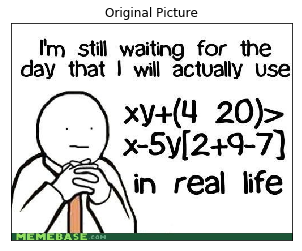

In [13]:
face_raw = Image.open(filename_0)
face = np.array(face_raw).astype(np.uint8)
h,w,c = face.shape

print('Image shape: {} x {} x {}'.format(h,w,c))
plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title('Original Picture')
plt.show()

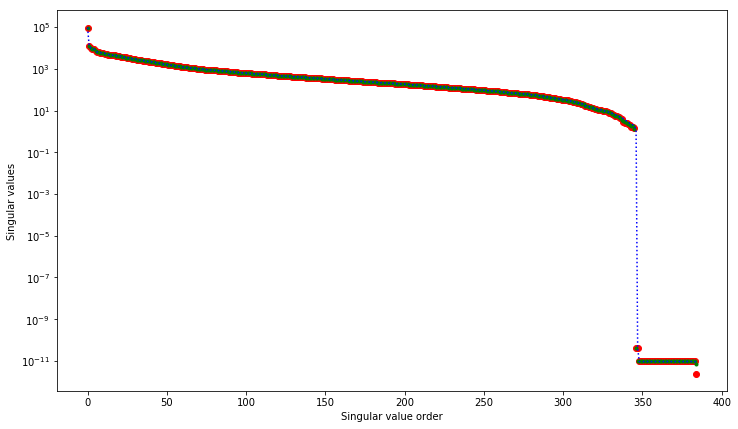

In [15]:
# Image is saved as a 3-dimensional array with shape H x W x C (heigt x width x channels)
Rf = face[:,:,0]
Gf = face[:,:,1]
Bf = face[:,:,2]

# Compute SVD and plot the singular values for different image channels
u, Rs, vh = np.linalg.svd(Rf, full_matrices=False)
u, Gs, vh = np.linalg.svd(Gf, full_matrices=False)
u, Bs, vh = np.linalg.svd(Bf, full_matrices=False)

plt.figure(figsize=(12,7))
plt.plot(Rs,'ro')
plt.plot(Gs,'g.')
plt.plot(Bs,'b:')
plt.yscale('log')
plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.show()

#### 2. Complete a function ```compress```, that performs SVD and truncates it (using $k$ singular values/vectors). See the prototype below. 

Note, that in case when your images are not grayscale you have to split your image to channels and work with matrices corresponding to different channels separately.

Plot approximate reconstructed image $M_\varepsilon$ of your favorite image such that $rank(M_\varepsilon) = 5, 20, 50$ using ```plt.subplots```.

In [26]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    image2 = image.copy()
    
    Rf = image2[:,:,0]
    Gf = image2[:,:,1]
    Bf = image2[:,:,2]
    
    # compute per-channel SVD for input image
    u_r, Rs, vh_r = np.linalg.svd(Rf, full_matrices=False) # <your code here>
    u_g, Gs, vh_g = np.linalg.svd(Gf, full_matrices=False) #
    u_b, Bs, vh_b = np.linalg.svd(Bf, full_matrices=False) #
    
    Rs = Rs[:k]
    Gs = Gs[:k]
    Bs = Bs[:k]
    
    # reconstruct the input image with the given approximation rank
    reduced_im = np.zeros((image.shape),np.uint8)
    
    red_channel = u_r[:,:k] @ np.diag(Rs) @ vh_r[:k,:]   # <your code here>
    green_channel = u_g[:,:k] @ np.diag(Gs) @ vh_g[:k,:] #
    blue_channel = u_b[:,:k] @ np.diag(Bs) @ vh_b[:k,:]  #
    
    reduced_im[...,0] = red_channel   #
    reduced_im[...,1] = green_channel #
    reduced_im[...,2] = blue_channel  #
    
    # save the array of top-k singular values
    s = np.zeros((len(Gs), 3))
    
    s[:,0] = Rs # <your code here>
    s[:,1] = Gs #
    s[:,2] = Bs #
    
    return reduced_im.copy(), s

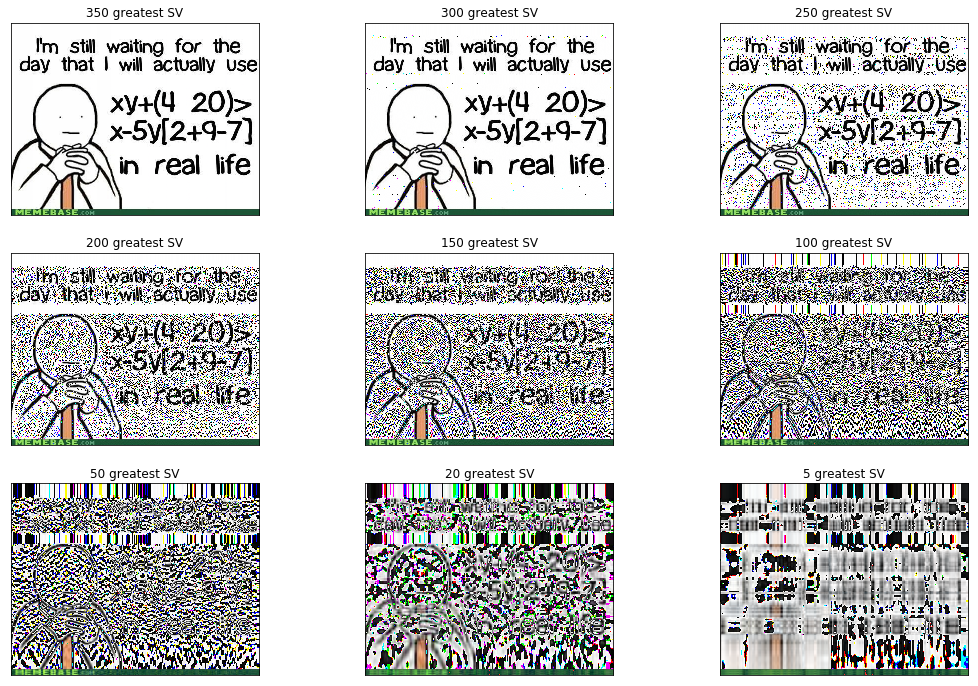

In [27]:
plt.figure(figsize=(18,12))
for i,k in enumerate([350,300,250,200,150,100,50,20,5]):
    plt.subplot(3,3,i+1)
    im,s = compress(face,k)
    plt.imshow(Image.fromarray(im,"RGB"))
    plt.xticks(())
    plt.yticks(())
    plt.title("{} greatest SV".format(k))

#### 3. Plot the following two figures for your favorite picture
* How relative error of approximation depends on the rank of approximation?
* How compression rate in terms of storing information ((singular vectors + singular numbers) / total size of image) depends on the rank of approximation?

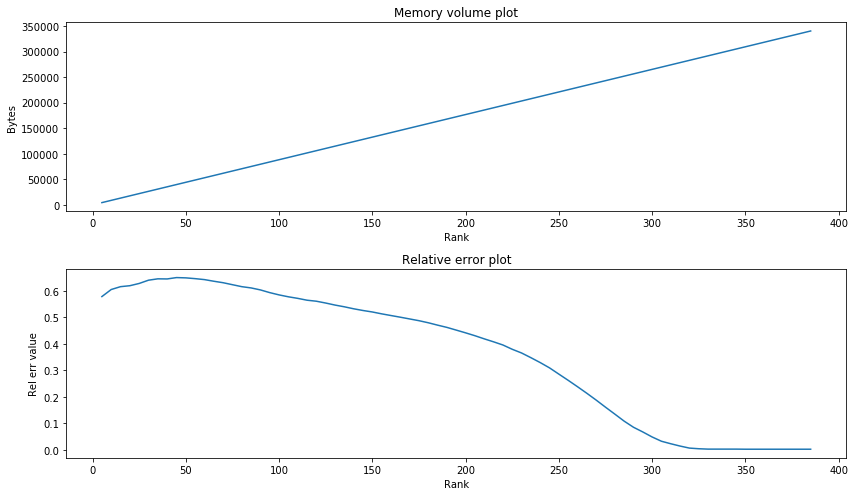

In [31]:
# fancy progress bar
from tqdm.auto import tqdm

k_list = range(5, 386, 5)
rel_err = []
info = []
for k in tqdm(k_list, leave=False):
    img, s = compress(face, k)
    
    current_relative_error = np.linalg.norm(img.astype(np.float64) - face.astype(np.float64))
    current_relative_error /= np.linalg.norm(face.astype(np.float64))# MSE(img, face) / l2_norm(face)
    current_information = k * (385 + 498 + 1) # U(image_height x K) @ S(diag KxK) @ V^T(K x image_width)
    
    rel_err.append(current_relative_error)
    info.append(current_information)
    
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.title("Memory volume plot")
plt.xlabel("Rank")
plt.ylabel("Bytes")
plt.plot(k_list, info)

plt.subplot(2,1,2)
plt.title("Relative error plot")
plt.xlabel("Rank")
plt.ylabel("Rel err value")
plt.plot(k_list, rel_err)

plt.tight_layout()
plt.show()

#### 4. Consider the following two pictures. Compute their approximations (with the same rank, or relative error). What do you see? Explain results.

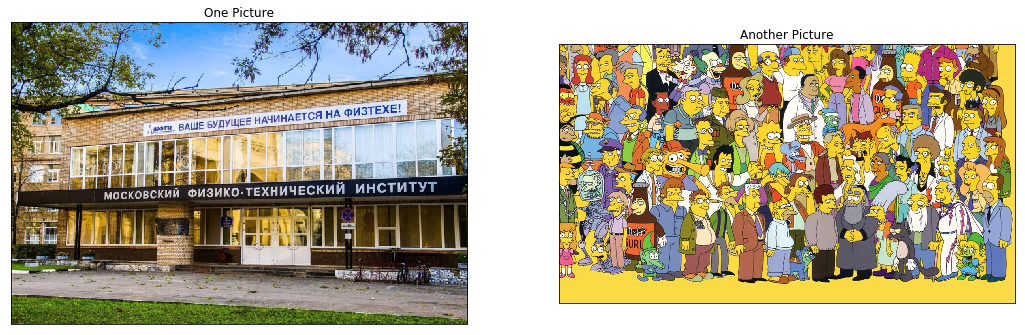

In [32]:
image_raw1 = Image.open(filename_1)
image_raw2 = Image.open(filename_2)

image1 = np.array(image_raw1).astype(np.uint8)
image2 = np.array(image_raw2).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.imshow(image_raw1)
plt.title('One Picture')
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(image_raw2)
plt.title('Another Picture')
plt.xticks(())
plt.yticks(())

plt.show()

### Same Rank

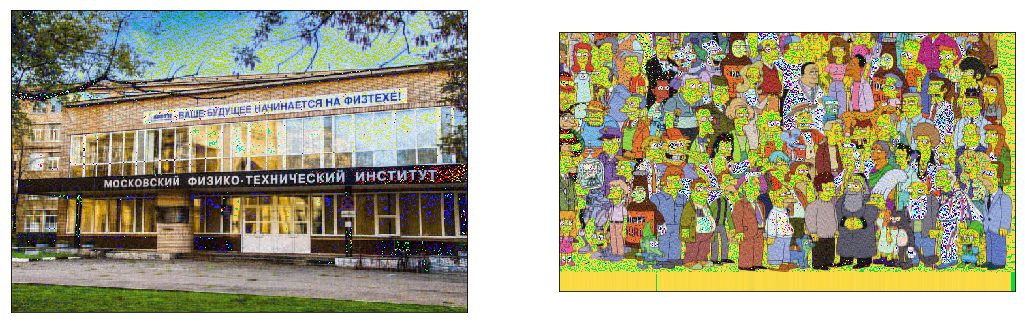

In [33]:
# Your code is here
im1, s = compress(image1, 100)
im2, s = compress(image2, 100)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(Image.fromarray(im1, "RGB"))
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(Image.fromarray(im2, "RGB"))
plt.xticks(())
plt.yticks(())

plt.show()

### Same Relative Error


K1 = 307; K2 = 417


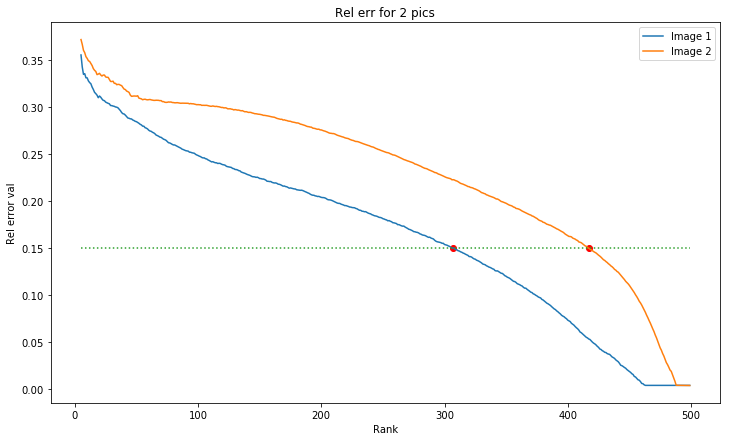

In [34]:
k_list = range(5,500,1)
rel_err1 = []
rel_err2 = []
relative_error_threshold = 0.15

for k in tqdm(k_list):
    image1_compressed, s = compress(image1, k)
    image2_compressed, s = compress(image2, k)
    
    # MSE(image1_compressed, image1) / l2_norm(image1)
    relative_error_1 = np.linalg.norm(image1_compressed.astype(np.float64) - image1.astype(np.float64))
    relative_error_1 /= np.linalg.norm(image1.astype(np.float64))
    
    # MSE(image2_compressed, image2) / l2_norm(image2)
    relative_error_2 = np.linalg.norm(image2_compressed.astype(np.float64) - image2.astype(np.float64))
    relative_error_2 /= np.linalg.norm(image2.astype(np.float64))

    
    rel_err1.append(relative_error_1)
    rel_err2.append(relative_error_2)

# find the indices
idx1 = int(np.argwhere(np.diff(np.sign(np.array(rel_err1) - relative_error_threshold))).flatten())
idx2 = int(np.argwhere(np.diff(np.sign(np.array(rel_err2) - relative_error_threshold))).flatten())
print("K1 = {}; K2 = {}".format(k_list[idx1], k_list[idx2]))

plt.figure(figsize=(12,7))

plt.plot(k_list[idx1], rel_err1[idx1], 'ro')
plt.plot(k_list[idx2], rel_err2[idx2], 'ro')
plt.title("Rel err for 2 pics")
plt.xlabel("Rank")
plt.ylabel("Rel error val")

plt.plot(k_list, rel_err1, label="Image 1")
plt.plot(k_list, rel_err2, label="Image 2")
plt.plot(k_list, [relative_error_threshold]*len(k_list),":",)

plt.legend()
plt.show()

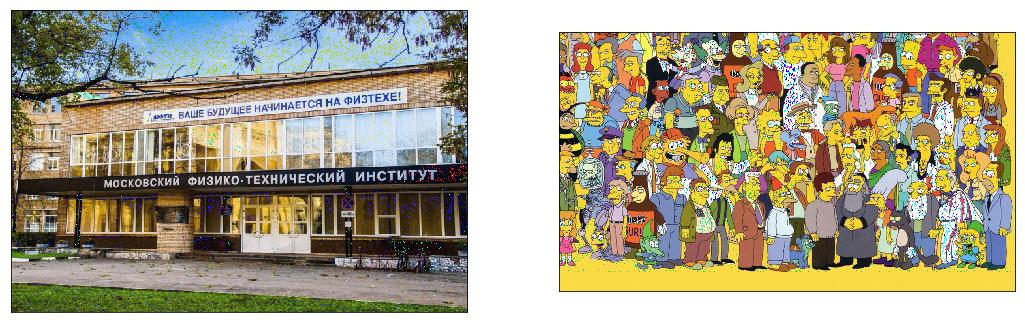

In [35]:
image1_compressed, s = compress(image1, k_list[idx1])
image2_compressed, s = compress(image2, k_list[idx2])

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(Image.fromarray(image1_compressed, "RGB"))
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(Image.fromarray(image2_compressed, "RGB"))
plt.xticks(())
plt.yticks(())
plt.show()